# Otter image classification

## data preprocess

### read from local files
```
dataset come from https://github.com/pl2599/Image-Classification-Otters
```

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


batch = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='data\otters', transform=transform)

print(dataset)
print(dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 349
    Root location: data\otters
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{'river': 0, 'sea': 1}


### split train, vaild and test

In [2]:
import torch
from torch.utils.data import random_split

total_size = len(dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(42) 
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}")
print(f"Valid: {len(valid_dataset)}")
print(f"Test : {len(test_dataset)}")

# shape
for images, labels in train_loader:
    print(images.shape, labels)
    break

Train: 244
Valid: 52
Test : 53
torch.Size([32, 3, 224, 224]) tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0])


## Training

### ResNet model

In [26]:
from torchvision.models  import resnet50, ResNet50_Weights
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Froze the previous layers
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False
    
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 2)
)
model = model.to(device)
print(device)


cuda


In [32]:
import torch.optim as optim

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [33]:
epochs = 40

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
for epoch in range(epochs):
    ### ---- Training ---- ###
    model.train()
    running_train_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_train_loss / total_train
    epoch_train_acc = train_correct / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    ### ---- Validation ---- ###
    model.eval()
    running_valid_loss = 0.0
    valid_correct = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_valid_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            valid_correct += (preds == labels).sum().item()
            total_valid += labels.size(0)

    epoch_valid_loss = running_valid_loss / total_valid
    epoch_valid_acc = valid_correct / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_acc)

    ### ---- Logging ---- ###
    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc*100:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f}, Acc: {epoch_valid_acc*100:.2f}%")

[Epoch 1] Train Loss: 0.0065, Acc: 100.00% | Valid Loss: 0.3292, Acc: 90.38%
[Epoch 2] Train Loss: 0.0016, Acc: 100.00% | Valid Loss: 0.3503, Acc: 86.54%
[Epoch 3] Train Loss: 0.0076, Acc: 100.00% | Valid Loss: 0.2849, Acc: 92.31%
[Epoch 4] Train Loss: 0.0012, Acc: 100.00% | Valid Loss: 0.3323, Acc: 92.31%
[Epoch 5] Train Loss: 0.0050, Acc: 100.00% | Valid Loss: 0.2811, Acc: 92.31%
[Epoch 6] Train Loss: 0.0041, Acc: 100.00% | Valid Loss: 0.3295, Acc: 92.31%
[Epoch 7] Train Loss: 0.0091, Acc: 99.59% | Valid Loss: 0.3658, Acc: 90.38%
[Epoch 8] Train Loss: 0.0143, Acc: 99.59% | Valid Loss: 0.3554, Acc: 90.38%
[Epoch 9] Train Loss: 0.0071, Acc: 100.00% | Valid Loss: 0.4078, Acc: 90.38%
[Epoch 10] Train Loss: 0.0042, Acc: 100.00% | Valid Loss: 0.3330, Acc: 92.31%


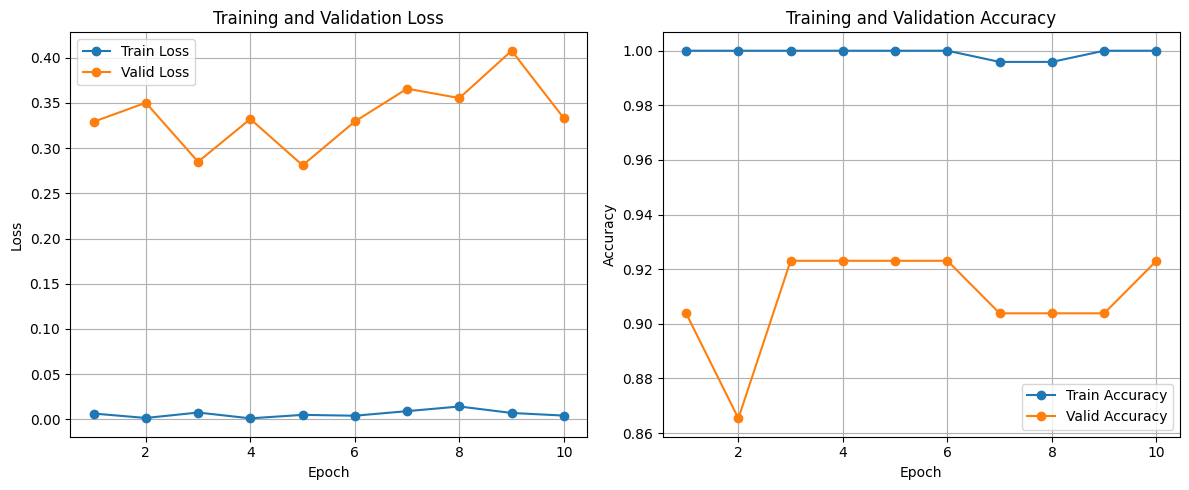

In [34]:
import matplotlib.pyplot as plt


epochs = range(1, epochs+1)

# Loss Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, valid_accuracies, label='Valid Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
test_correct = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        total_test += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / total_test
print(f" Test Accuracy: {test_acc*100:.2f}%")

 Test Accuracy: 98.11%



📄 Classification Report:
              precision    recall  f1-score   support

       river       0.92      1.00      0.96        24
         sea       1.00      0.93      0.96        29

    accuracy                           0.96        53
   macro avg       0.96      0.97      0.96        53
weighted avg       0.97      0.96      0.96        53



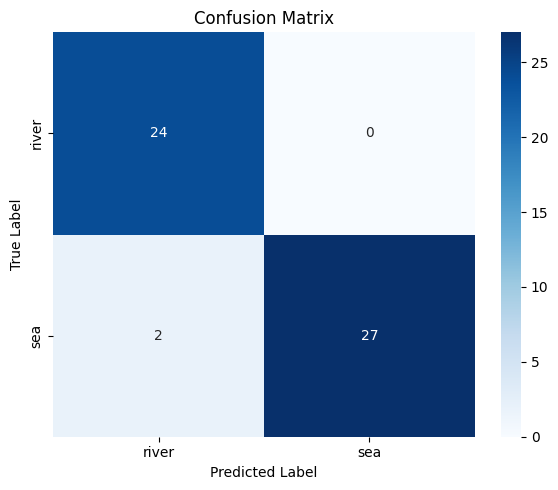

In [39]:
# 如果你有 label mapping，例如：
label_map = {0: 'river', 1: 'sea'}
target_names = [label_map[i] for i in sorted(label_map)]

# 分類報告
print("\n📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# 混淆矩陣
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, "otter_classifier_full.pth")

In [1]:
from PIL import Image
import torch
def predict_image(filepath, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    image = Image.open(filepath).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # [1, 3, 224, 224]

    with torch.no_grad():
        outputs = model(image)
        _, pred = torch.max(outputs, 1)
        class_index = pred.item()
        class_name = label_map[class_index]

    return class_name

def show_prediction(filepath, result):
    image = Image.open(filepath).convert('RGB')

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"{result} otter", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
label_map = {0: 'river', 1: 'sea'}
target_names = [label_map[i] for i in sorted(label_map)]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

model = torch.load("otter_classifier_full.pth")
model.eval()

files = ["data\otter.jpg", "data\otter2.jpg"]
for filepath in files:
    result = predict_image(filepath, model)
    show_prediction(filepath, result)